In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
import xarray as xr

from scipy.stats import binned_statistic
import matplotlib.transforms as mtransforms

In [2]:
colorblind_safe_colors = sns.color_palette("Set2")
colors = {'weak': colorblind_safe_colors[3], 'mid':colorblind_safe_colors[1], 'strong':colorblind_safe_colors[2]}

In [3]:
scenario = 'ssp126'

temperature = pd.read_csv(f'../data_output/fair_temperature/{scenario}.csv', index_col='year')
observations = pd.read_csv('../data_input/gsat/ar6_four_set_mean_gmst.csv', index_col='Year')

#  Tweak the units label for journal consistency
ecs_ds = xr.open_dataset(f'../data_output/ecs_constraints_{scenario}.nc').rename({"Uncertainty in 2100 temperature change (K)": "Uncertainty in 2100 temperature change [K]"},)
erf_ds = xr.open_dataset(f'../data_output/erf_constraints_{scenario}.nc').rename({"Uncertainty in 2100 temperature change (K)": "Uncertainty in 2100 temperature change [K]"},)


In [4]:
weak_aer = erf_ds.isel(shifts=4, scalings=4).constraint.values
mid_aer = erf_ds.isel(shifts=2, scalings=4).constraint.values
strong_aer = erf_ds.isel(shifts=0, scalings=4).constraint.values

low_ECS = ecs_ds.isel(shifts=0, scalings=4).constraint.values
mid_ECS = ecs_ds.isel(shifts=2, scalings=4).constraint.values
high_ECS = ecs_ds.isel(shifts=4, scalings=4).constraint.values

<ipython-input-5-72d51d0185e4>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(temperature[1980:].index, bins, temp_prob)


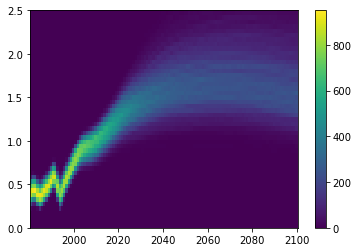

In [5]:
bins = np.linspace(0, 2.5, 50)
temp_prob = temperature.apply(lambda x: np.histogram(x, bins=bins, density=False)[0], axis=1, result_type='expand')[1980:].values.T
plt.pcolormesh(temperature[1980:].index, bins, temp_prob)
plt.colorbar()

In [6]:
def get_robust_errs(df, confidence=0.1):
    # Get values suitable for errorbars
    return np.diff(df.quantile([confidence, 0.5, 1-confidence]))[:, np.newaxis]

get_robust_errs(temperature.iloc[-1, weak_aer])

array([[0.2516],
       [0.1724]])

/Users/watson-parris/miniconda3/envs/xarray/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
<ipython-input-7-c9fdb908cfcc>:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p=plt.pcolormesh(temperature[1980:].index, bins,


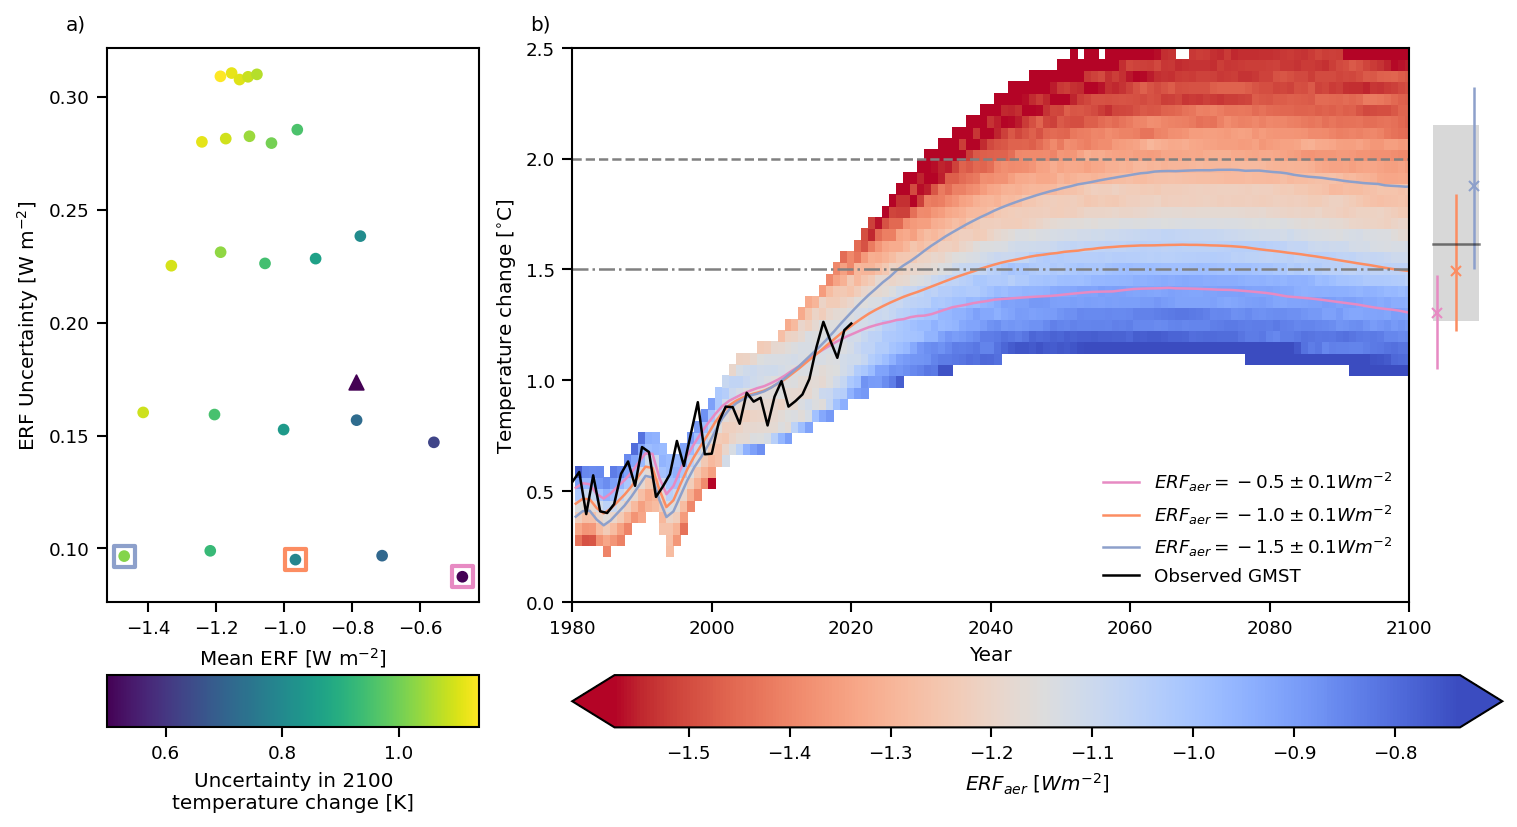

In [7]:

with sns.plotting_context('paper'):

    normed_temp_prob = (temp_prob/temp_prob.max(axis=0))
    
    def get_mean_erf(s):
        mean = binned_statistic(s, erf_ds['ERF'], bins=bins, statistic='mean')[0]
        count = np.histogram(s, bins=bins, density=True)[0]
        return np.where(count>0.1, mean, np.nan)
#         return mean
    
    fig = plt.figure(figsize=(12,6), dpi=150)
    
    gs = fig.add_gridspec(11, 15,wspace=0.)
    ax1 = fig.add_subplot(gs[:-2,0:4])
    
    cbar_ax1 = fig.add_subplot(gs[-1,0:4])
    
    # Uncertainty plot
    erf_ds.plot.scatter('Mean ERF', 'ERF Uncertainty', hue='Uncertainty in 2100 temperature change [K]', ax=ax1, cbar_kwargs=dict(cax=cbar_ax1, orientation='horizontal'))
    plt.setp(ax1, xlabel='Mean ERF [W m$^{-2}$]', ylabel='ERF Uncertainty [W m$^{-2}$]')
    ax1.scatter(erf_ds.ERF.where(erf_ds.ERF>-1).mean('member'), erf_ds.ERF.where(erf_ds.ERF>-1).std('member'), 
               c=temperature.loc[2100.5, erf_ds.ERF.values>-1].quantile([0.05, 0.95]).diff()[0.95], marker='^', s=50)

    
    ax1.scatter(erf_ds.ERF.where(weak_aer).mean('member'), erf_ds.ERF.where(weak_aer).std('member'), edgecolor=colors['weak'], marker='s', s=100, facecolor='none', linewidth=2)
    ax1.scatter(erf_ds.ERF.where(mid_aer).mean('member'), erf_ds.ERF.where(mid_aer).std('member'), edgecolor=colors['mid'], marker='s', s=100, facecolor='none', linewidth=2)
    ax1.scatter(erf_ds.ERF.where(strong_aer).mean('member'), erf_ds.ERF.where(strong_aer).std('member'), edgecolor=colors['strong'], marker='s', s=100, facecolor='none', linewidth=2)
    
    ax2 = fig.add_subplot(gs[:-2,5:-1])

    divnorm = TwoSlopeNorm(*erf_ds['ERF'].quantile([0.5, 0.1, 0.9]).values)
    
    # p=plt.pcolormesh(ssp_119_erf.index[230:330], bins, np.stack(res)[230:330].T, cmap='RdBu', vmin=-1.5, vmax=-0.5)#, edgecolor='face', shading='auto')
    p=plt.pcolormesh(temperature[1980:].index, bins, 
                     temperature.apply(get_mean_erf, axis=1, result_type='expand')[1980:].values.T,
                    cmap='coolwarm_r', norm=divnorm)

    temperature.loc[1980:, weak_aer].median(axis=1).plot(label='$ERF_{aer}=-0.5\pm0.1 Wm^{-2}$', c=colors['weak'])
    temperature.loc[1980:, mid_aer].median(axis=1).plot(label='$ERF_{aer}=-1.0\pm0.1 Wm^{-2}$', c=colors['mid'])
    temperature.loc[1980:, strong_aer].median(axis=1).plot(label='$ERF_{aer}=-1.5\pm0.1 Wm^{-2}$', c=colors['strong'])
    
    # Save these for the next plot...
    handles, labels = plt.gca().get_legend_handles_labels()
    
    observations.loc[1980:].rename(columns=dict(GMST='Observed GMST')).plot(ax=plt.gca(), color='k')
    
    plt.gca().axhline(1.5, ls='-.', c='grey')
    plt.gca().axhline(2, ls='--', c='grey')
    plt.setp(plt.gca(), xlim=[1980, 2100], xlabel='Year', ylabel='Temperature change [$^{\circ}$C]')
    plt.legend(frameon=False)

    cbar_ax2 = fig.add_subplot(gs[-1,5:])
    plt.colorbar(p, extend='both', label='$ERF_{aer}$ [$Wm^{-2}$]', orientation='horizontal', cax=cbar_ax2)

    
    # Do the end of century ranges
    ax3 = fig.add_subplot(gs[0:-2,-1])
    ax3.errorbar([-.8],
                 temperature.iloc[-1, weak_aer].median(),
                 get_robust_errs(temperature.iloc[-1, weak_aer]), fmt='x', c=colors['weak']
                )

    # Add a patch for the full ensemble
    all_mid = temperature.iloc[-1, :].median()
    all_low, all_high = get_robust_errs(temperature.iloc[-1, :]).T[0]
    from matplotlib.patches import Rectangle
    ax3.add_patch(Rectangle((-1., all_mid-all_low), 2., all_high+all_low, alpha=0.3, facecolor='gray', edgecolor='none'))
    ax3.plot([-1., 1.], [all_mid, all_mid], marker='', c='k', alpha=0.5)
    
    ax3.errorbar([0],
                 temperature.iloc[-1, mid_aer].median(),
                 get_robust_errs(temperature.iloc[-1, mid_aer]), fmt='x', c=colors['mid']
                )
    ax3.errorbar([.8],
                 temperature.iloc[-1, strong_aer].median(),
                 get_robust_errs(temperature.iloc[-1, strong_aer]), fmt='x', c=colors['strong']
                )
    ax3.axis('off')
    plt.setp(ax3, xlim=[-2, 2], ylim=[0., 2.5])
    
#     cbar_ax = fig.add_subplot(gs[0,-2])

    for label, ax in zip(['a)', 'b)'], [ax1, ax2]):
        # label physical distance to the left and up:
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='medium', va='bottom')

#     plt.tight_layout()
    plt.savefig("Figure_1.pdf", bbox_inches="tight")
    plt.show()
    

In [8]:
joint_df = pd.DataFrame({'ERF':erf_ds['ERF'].values, 'ECS': ecs_ds['ECS'].values, 'T':temperature[2045:2055].mean(axis=0).values})

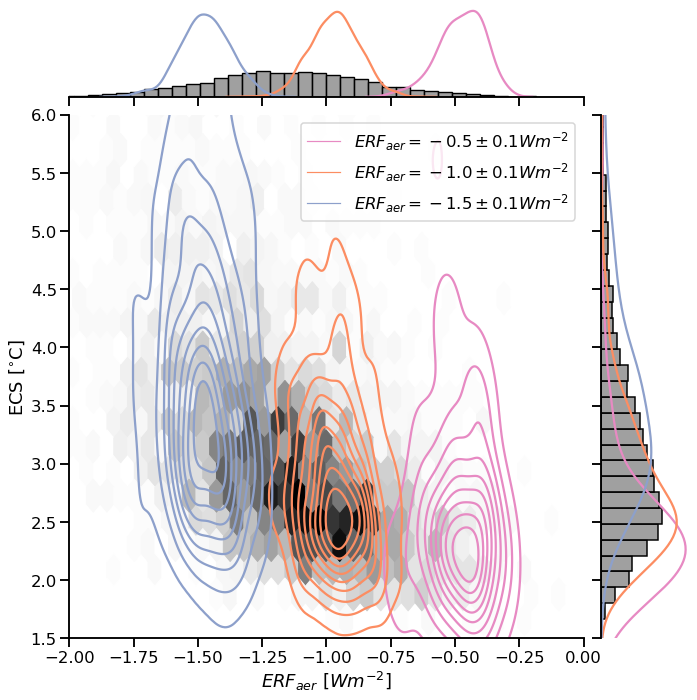

In [9]:

with sns.plotting_context("talk"):

    g = sns.jointplot(data=joint_df, x='ERF', y='ECS', kind='hex', marginal_kws=dict(stat='density', color='gray'), xlim=[-2, 0], ylim=[1.5, 6], height=10, cmap='Greys')

    sns.kdeplot(data=joint_df[weak_aer], x='ERF', y='ECS', ax=g.ax_joint, color=colors['weak'], label='Weak')
    sns.kdeplot(data=joint_df[weak_aer], x='ERF', ax=g.ax_marg_x, color=colors['weak'])
    sns.kdeplot(data=joint_df[weak_aer], y='ECS', ax=g.ax_marg_y, color=colors['weak'])

    sns.kdeplot(data=joint_df[mid_aer], x='ERF', y='ECS', ax=g.ax_joint, color=colors['mid'])
    sns.kdeplot(data=joint_df[mid_aer], x='ERF', ax=g.ax_marg_x, color=colors['mid'])
    sns.kdeplot(data=joint_df[mid_aer], y='ECS', ax=g.ax_marg_y, color=colors['mid'])

    sns.kdeplot(data=joint_df[strong_aer], x='ERF', y='ECS', ax=g.ax_joint, color=colors['strong'])
    sns.kdeplot(data=joint_df[strong_aer], x='ERF', ax=g.ax_marg_x, color=colors['strong'])
    sns.kdeplot(data=joint_df[strong_aer], y='ECS', ax=g.ax_marg_y, color=colors['strong'])

    plt.setp(g.ax_joint, xlabel='$ERF_{aer}$ $[Wm^{-2}]$', ylabel='ECS [$^{\circ}$C]')
    g.ax_joint.legend(handles, labels)
    plt.savefig("Figure_2.pdf", dpi=150)
    plt.show()

    

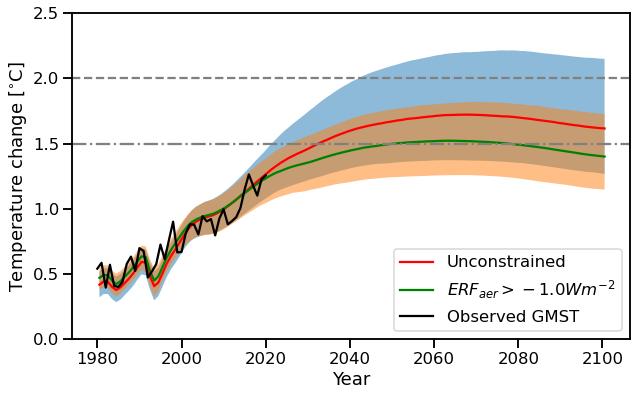

In [10]:
# 1 Wm-2 constraint

with sns.plotting_context('talk'):
    plt.figure(figsize=(10,6))
    
    temperature.loc[1980:].median(axis=1).plot(label='Unconstrained', c='r')
    plt.fill_between(temperature.loc[1980:].index, temperature.loc[1980:].quantile(0.1, axis=1).values, temperature.loc[1980:].quantile(0.9, axis=1).values, alpha=0.5)
    temperature.loc[1980:, erf_ds['ERF'].values>-1.].median(axis=1).plot(label='$ERF_{aer}>-1.0 Wm^{-2}$', c='g')
    plt.fill_between(temperature.loc[1980:, erf_ds['ERF'].values>-1.].index, temperature.loc[1980:, erf_ds['ERF'].values>-1.].quantile(0.1, axis=1).values, temperature.loc[1980:, erf_ds['ERF'].values>-1.].quantile(0.9, axis=1).values, alpha=0.5)

    # Save these for the next plot...
    handles, labels = plt.gca().get_legend_handles_labels()
    
    observations.loc[1980:].rename(columns=dict(GMST='Observed GMST')).plot(ax=plt.gca(), color='k')
    
    plt.gca().axhline(1.5, ls='-.', c='grey')
    plt.gca().axhline(2, ls='--', c='grey')
    plt.setp(plt.gca(), xlabel='Year', ylabel='Temperature change [$^{\circ}$C]', ylim=[0., 2.5])
    plt.legend()
    plt.show()
    




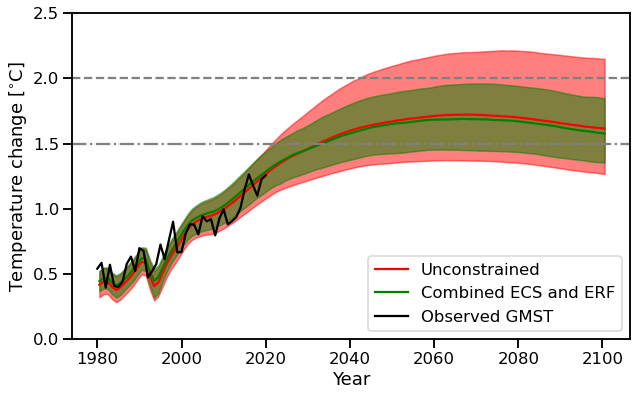

2.16301
1.7456800000000001


In [11]:
# Joint constraint

with sns.plotting_context('talk'):
    plt.figure(figsize=(10,6))
    
    temperature.loc[1980:].median(axis=1).plot(label='Unconstrained', c='r')
    plt.fill_between(temperature.loc[1980:].index, temperature.loc[1980:].quantile(0.1, axis=1).values, temperature.loc[1980:].quantile(0.9, axis=1).values, alpha=0.5, color='r')
    temperature.loc[1980:, mid_aer&mid_ECS].median(axis=1).plot(label='Combined ECS and ERF', c='g')
    plt.fill_between(temperature.loc[1980:, mid_aer&mid_ECS].index, temperature.loc[1980:, mid_aer&mid_ECS].quantile(0.1, axis=1).values, temperature.loc[1980:, mid_aer&mid_ECS].quantile(0.9, axis=1).values, alpha=0.5, color='g')

    # Save these for the next plot...
    handles, labels = plt.gca().get_legend_handles_labels()
    
    observations.loc[1980:].rename(columns=dict(GMST='Observed GMST')).plot(ax=plt.gca(), color='k')
    
    plt.gca().axhline(1.5, ls='-.', c='grey')
    plt.gca().axhline(2, ls='--', c='grey')
    plt.setp(plt.gca(), xlabel='Year', ylabel='Temperature change [$^{\circ}$C]', ylim=[0., 2.5])
    plt.legend()
#     plt.savefig("Figure_S3.pdf")
    plt.show()
    
print(temperature.quantile(0.9, axis=1).loc[2090:2100].mean())
print(temperature.loc[:, erf_ds['ERF'].values>-1.].quantile(0.9, axis=1).loc[2090:2100].mean())

/Users/watson-parris/miniconda3/envs/xarray/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
<ipython-input-12-4bdd3feb70ec>:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p=plt.pcolormesh(temperature[1980:].index, bins,
<ipython-input-12-4bdd3feb70ec>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_subplot(gs[:-2,5:-1])
<ipython-inp

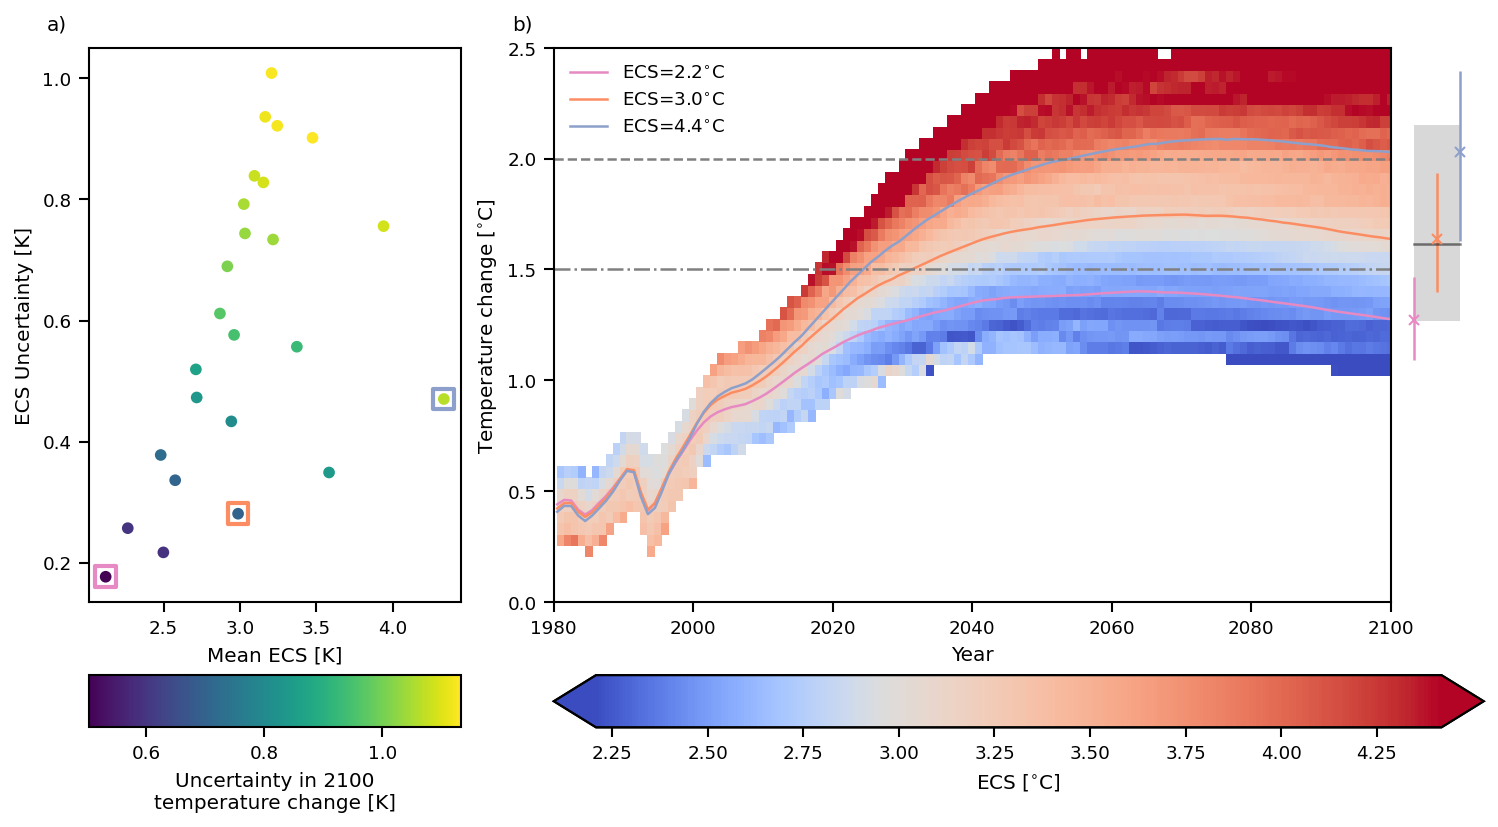

In [12]:


with sns.plotting_context('paper'):

    normed_temp_prob = (temp_prob/temp_prob.max(axis=0))
    
    def get_mean_erf(s):
        mean = binned_statistic(s, ecs_ds.ECS, bins=bins, statistic='mean')[0]
        count = np.histogram(s, bins=bins, density=True)[0]
        return np.where(count>0.1, mean, np.nan)
#         return mean
    
    fig = plt.figure(figsize=(12,6), dpi=150)
    
    gs = fig.add_gridspec(11, 15,wspace=0.)
    ax1 = fig.add_subplot(gs[:-2,0:4])
    
    cbar_ax1 = fig.add_subplot(gs[-1,0:4])
    
    # Uncertainty plot
    ecs_ds.plot.scatter('Mean ECS', 'ECS Uncertainty', hue='Uncertainty in 2100 temperature change [K]', ax=ax1, cbar_kwargs=dict(cax=cbar_ax1, orientation='horizontal'))
    plt.setp(ax1, xlabel='Mean ECS [K]', ylabel='ECS Uncertainty [K]')
    
    ax1.scatter(ecs_ds.ECS.where(low_ECS).mean('member'), ecs_ds.ECS.where(low_ECS).std('member'), edgecolor=colors['weak'], marker='s', s=100, facecolor='none', linewidth=2)
    ax1.scatter(ecs_ds.ECS.where(mid_ECS).mean('member'), ecs_ds.ECS.where(mid_ECS).std('member'), edgecolor=colors['mid'], marker='s', s=100, facecolor='none', linewidth=2)
    ax1.scatter(ecs_ds.ECS.where(high_ECS).mean('member'), ecs_ds.ECS.where(high_ECS).std('member'), edgecolor=colors['strong'], marker='s', s=100, facecolor='none', linewidth=2)
    

    divnorm = TwoSlopeNorm(*ecs_ds.ECS.quantile([0.5, 0.1, 0.9]).values)

    
    ax2 = fig.add_subplot(gs[:-2,5:-1])

    # p=plt.pcolormesh(ssp_119_erf.index[230:330], bins, np.stack(res)[230:330].T, cmap='RdBu', vmin=-1.5, vmax=-0.5)#, edgecolor='face', shading='auto')
    p=plt.pcolormesh(temperature[1980:].index, bins, 
                     temperature.apply(get_mean_erf, axis=1, result_type='expand')[1980:].values.T,
                    cmap='coolwarm', norm=divnorm)
    

    temperature.loc[1980:, low_ECS].median(axis=1).plot(label='ECS=$2.2^{\circ}$C', c=colors['weak'])
    temperature.loc[1980:, mid_ECS].median(axis=1).plot(label='ECS=$3.0^{\circ}$C', c=colors['mid'])
    temperature.loc[1980:, high_ECS].median(axis=1).plot(label='ECS=$4.4^{\circ}$C', c=colors['strong'])
    
    ax2 = fig.add_subplot(gs[:-2,5:-1])

    divnorm = TwoSlopeNorm(*erf_ds['ERF'].quantile([0.5, 0.1, 0.9]).values)
    
    plt.gca().axhline(1.5, ls='-.', c='grey')
    plt.gca().axhline(2, ls='--', c='grey')
    plt.setp(plt.gca(), xlim=[1980, 2100], xlabel='Year', ylabel='Temperature change [$^{\circ}$C]')
    plt.legend(frameon=False)

    cbar_ax2 = fig.add_subplot(gs[-1,5:])
    plt.colorbar(p, extend='both', label='$ERF_{aer}$ $[Wm^{-2}]$', orientation='horizontal', cax=cbar_ax2)

    
    cbar_ax2 = fig.add_subplot(gs[-1,5:])
    plt.colorbar(p, extend='both', label='ECS [$^{\circ}$C]', orientation='horizontal', cax=cbar_ax2)

    
    # Do the end of century ranges
    ax3 = fig.add_subplot(gs[0:-2,-1])
    ax3.errorbar([-1.],
                 temperature.iloc[-1, low_ECS].median(),
                 get_robust_errs(temperature.iloc[-1, low_ECS]), fmt='x', c=colors['weak']
                )
    ax3.errorbar([0],
                 temperature.iloc[-1, mid_ECS].median(),
                 get_robust_errs(temperature.iloc[-1, mid_ECS]), fmt='x', c=colors['mid']
                )

    # Add a patch for the full ensemble
    all_mid = temperature.iloc[-1, :].median()
    all_low, all_high = get_robust_errs(temperature.iloc[-1, :]).T[0]
    from matplotlib.patches import Rectangle
    ax3.add_patch(Rectangle((-1., all_mid-all_low), 2., all_high+all_low, alpha=0.3, facecolor='gray', edgecolor='none'))
    ax3.plot([-1., 1.], [all_mid, all_mid], marker='', c='k', alpha=0.5)

    ax3.errorbar([1.],
                 temperature.iloc[-1, high_ECS].median(),
                 get_robust_errs(temperature.iloc[-1, high_ECS]), fmt='x', c=colors['strong']
                )
    ax3.axis('off')
    plt.setp(ax3, xlim=[-2, 2], ylim=[0., 2.5])
    
    for label, ax in zip(['a)', 'b)'], [ax1, ax2]):
        # label physical distance to the left and up:
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='medium', va='bottom')

#     plt.tight_layout()
    plt.savefig("Figure_S2.pdf", bbox_inches="tight")
    plt.show()
    

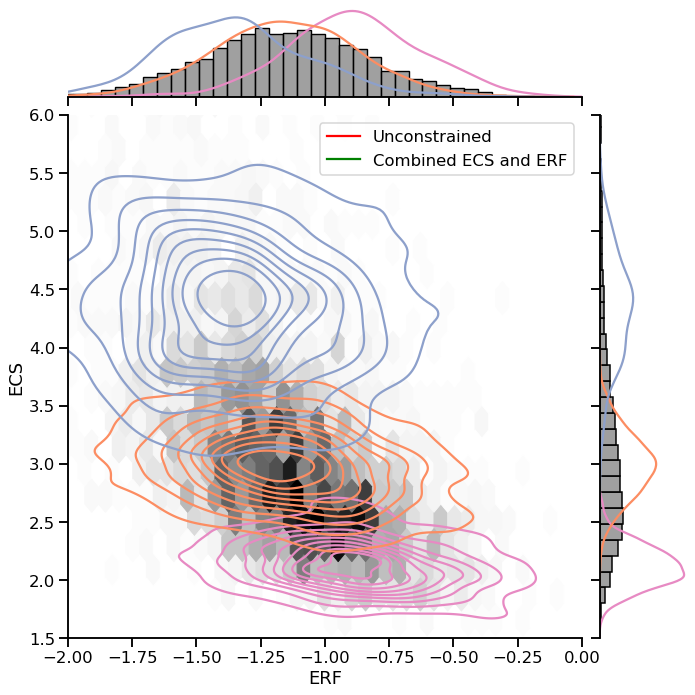

In [13]:
with sns.plotting_context("talk"):

    g = sns.jointplot(data=joint_df, x='ERF', y='ECS', kind='hex', marginal_kws=dict(stat='density', color='gray'), xlim=[-2, 0], ylim=[1.5, 6], height=10, cmap='Greys')

    sns.kdeplot(data=joint_df[low_ECS], x='ERF', y='ECS', ax=g.ax_joint, color=colors['weak'])
    sns.kdeplot(data=joint_df[low_ECS], x='ERF', ax=g.ax_marg_x, color=colors['weak'])
    sns.kdeplot(data=joint_df[low_ECS], y='ECS', ax=g.ax_marg_y, color=colors['weak'])

    sns.kdeplot(data=joint_df[mid_ECS], x='ERF', y='ECS', ax=g.ax_joint, color=colors['mid'])
    sns.kdeplot(data=joint_df[mid_ECS], x='ERF', ax=g.ax_marg_x, color=colors['mid'])
    sns.kdeplot(data=joint_df[mid_ECS], y='ECS', ax=g.ax_marg_y, color=colors['mid'])

    sns.kdeplot(data=joint_df[high_ECS], x='ERF', y='ECS', ax=g.ax_joint, color=colors['strong'])
    sns.kdeplot(data=joint_df[high_ECS], x='ERF', ax=g.ax_marg_x, color=colors['strong'])
    sns.kdeplot(data=joint_df[high_ECS], y='ECS', ax=g.ax_marg_y, color=colors['strong'])

    g.ax_joint.legend(handles, labels)
#     plt.savefig("Figure_S3.pdf")
    plt.show()


/Users/watson-parris/miniconda3/envs/xarray/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
<ipython-input-14-433a34f8a1eb>:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p=plt.pcolormesh(temperature[1980:].index, bins,


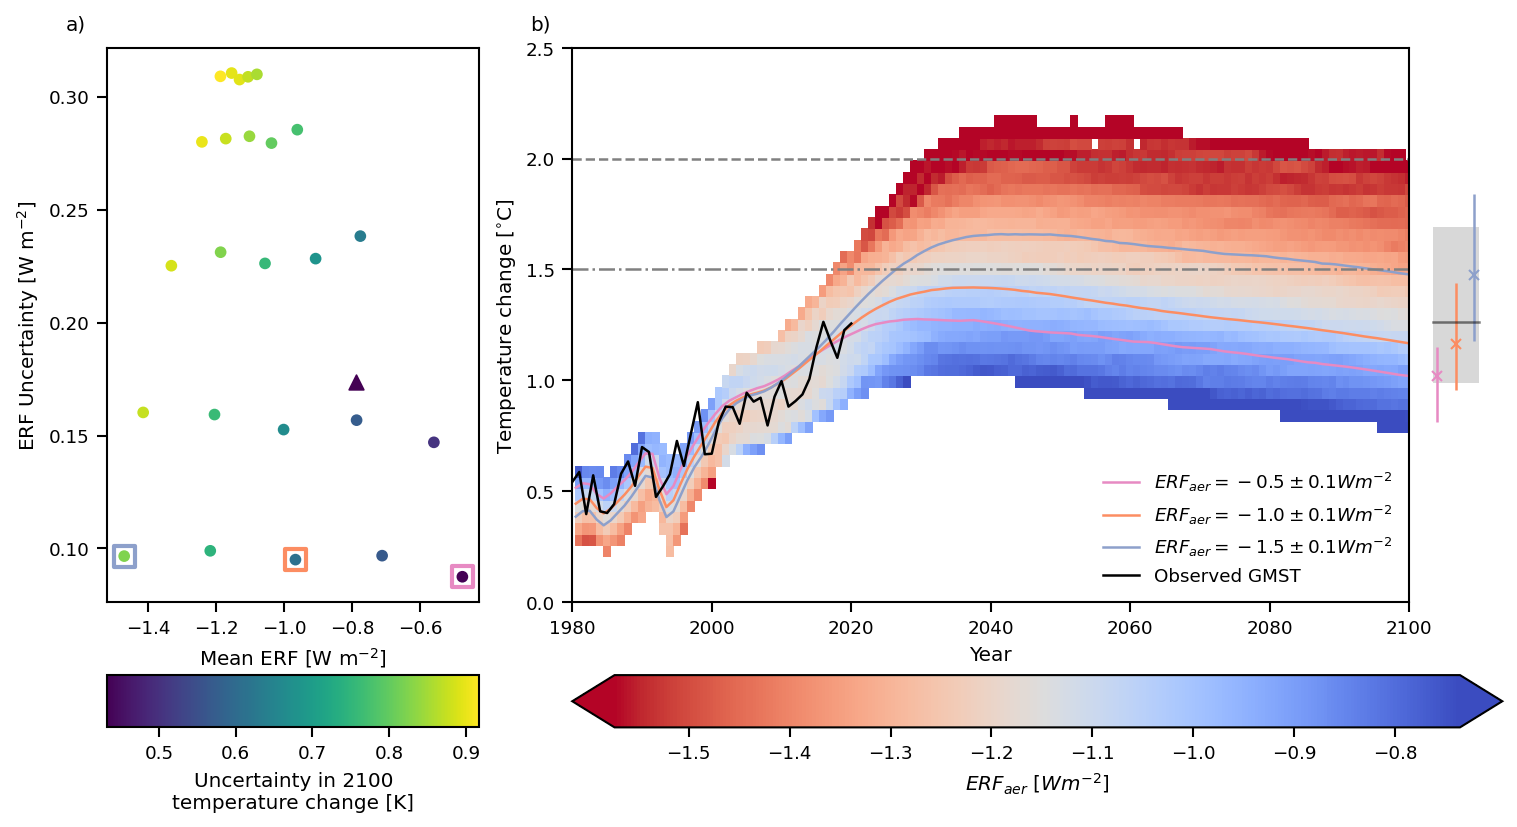

In [14]:
scenario = 'ssp119'

temperature = pd.read_csv(f'../data_output/fair_temperature/{scenario}.csv', index_col='year')
observations = pd.read_csv('../data_input/gsat/ar6_four_set_mean_gmst.csv', index_col='Year')

ecs_ds = xr.open_dataset(f'../data_output/ecs_constraints_{scenario}.nc').rename({"Uncertainty in 2100 temperature change (K)": "Uncertainty in 2100 temperature change [K]"},)
erf_ds = xr.open_dataset(f'../data_output/erf_constraints_{scenario}.nc').rename({"Uncertainty in 2100 temperature change (K)": "Uncertainty in 2100 temperature change [K]"},)

weak_aer = erf_ds.isel(shifts=4, scalings=4).constraint.values
mid_aer = erf_ds.isel(shifts=2, scalings=4).constraint.values
strong_aer = erf_ds.isel(shifts=0, scalings=4).constraint.values

low_ECS = ecs_ds.isel(shifts=0, scalings=4).constraint.values
mid_ECS = ecs_ds.isel(shifts=2, scalings=4).constraint.values
high_ECS = ecs_ds.isel(shifts=4, scalings=4).constraint.values


with sns.plotting_context('paper'):

    normed_temp_prob = (temp_prob/temp_prob.max(axis=0))
    
    def get_mean_erf(s):
        mean = binned_statistic(s, erf_ds['ERF'], bins=bins, statistic='mean')[0]
        count = np.histogram(s, bins=bins, density=True)[0]
        return np.where(count>0.1, mean, np.nan)
#         return mean
    
    fig = plt.figure(figsize=(12,6), dpi=150)
    
    gs = fig.add_gridspec(11, 15,wspace=0.)
    ax1 = fig.add_subplot(gs[:-2,0:4])
    
    cbar_ax1 = fig.add_subplot(gs[-1,0:4])
    
    # Uncertainty plot
    erf_ds.plot.scatter('Mean ERF', 'ERF Uncertainty', hue='Uncertainty in 2100 temperature change [K]', ax=ax1, cbar_kwargs=dict(cax=cbar_ax1, orientation='horizontal'))
    plt.setp(ax1, xlabel='Mean ERF [W m$^{-2}$]', ylabel='ERF Uncertainty [W m$^{-2}$]')
    ax1.scatter(erf_ds.ERF.where(erf_ds.ERF>-1).mean('member'), erf_ds.ERF.where(erf_ds.ERF>-1).std('member'), 
               c=temperature.loc[2100.5, erf_ds.ERF.values>-1].quantile([0.05, 0.95]).diff()[0.95], marker='^', s=50)

    
    ax1.scatter(erf_ds.ERF.where(weak_aer).mean('member'), erf_ds.ERF.where(weak_aer).std('member'), edgecolor=colors['weak'], marker='s', s=100, facecolor='none', linewidth=2)
    ax1.scatter(erf_ds.ERF.where(mid_aer).mean('member'), erf_ds.ERF.where(mid_aer).std('member'), edgecolor=colors['mid'], marker='s', s=100, facecolor='none', linewidth=2)
    ax1.scatter(erf_ds.ERF.where(strong_aer).mean('member'), erf_ds.ERF.where(strong_aer).std('member'), edgecolor=colors['strong'], marker='s', s=100, facecolor='none', linewidth=2)
    
    ax2 = fig.add_subplot(gs[:-2,5:-1])

    divnorm = TwoSlopeNorm(*erf_ds['ERF'].quantile([0.5, 0.1, 0.9]).values)
    
    # p=plt.pcolormesh(ssp_119_erf.index[230:330], bins, np.stack(res)[230:330].T, cmap='RdBu', vmin=-1.5, vmax=-0.5)#, edgecolor='face', shading='auto')
    p=plt.pcolormesh(temperature[1980:].index, bins, 
                     temperature.apply(get_mean_erf, axis=1, result_type='expand')[1980:].values.T,
                    cmap='coolwarm_r', norm=divnorm)

    temperature.loc[1980:, weak_aer].median(axis=1).plot(label='$ERF_{aer}=-0.5\pm0.1 Wm^{-2}$', c=colors['weak'])
    temperature.loc[1980:, mid_aer].median(axis=1).plot(label='$ERF_{aer}=-1.0\pm0.1 Wm^{-2}$', c=colors['mid'])
    temperature.loc[1980:, strong_aer].median(axis=1).plot(label='$ERF_{aer}=-1.5\pm0.1 Wm^{-2}$', c=colors['strong'])
    
    # Save these for the next plot...
    handles, labels = plt.gca().get_legend_handles_labels()
    
    observations.loc[1980:].rename(columns=dict(GMST='Observed GMST')).plot(ax=plt.gca(), color='k')
    
    plt.gca().axhline(1.5, ls='-.', c='grey')
    plt.gca().axhline(2, ls='--', c='grey')
    plt.setp(plt.gca(), xlim=[1980, 2100], xlabel='Year', ylabel='Temperature change [$^{\circ}$C]')
    plt.legend(frameon=False)

    cbar_ax2 = fig.add_subplot(gs[-1,5:])
    plt.colorbar(p, extend='both', label='$ERF_{aer}$ [$Wm^{-2}$]', orientation='horizontal', cax=cbar_ax2)

    
    # Do the end of century ranges
    ax3 = fig.add_subplot(gs[0:-2,-1])
    ax3.errorbar([-.8],
                 temperature.iloc[-1, weak_aer].median(),
                 get_robust_errs(temperature.iloc[-1, weak_aer]), fmt='x', c=colors['weak']
                )

    # Add a patch for the full ensemble
    all_mid = temperature.iloc[-1, :].median()
    all_low, all_high = get_robust_errs(temperature.iloc[-1, :]).T[0]
    from matplotlib.patches import Rectangle
    ax3.add_patch(Rectangle((-1., all_mid-all_low), 2., all_high+all_low, alpha=0.3, facecolor='gray', edgecolor='none'))
    ax3.plot([-1., 1.], [all_mid, all_mid], marker='', c='k', alpha=0.5)
    
    ax3.errorbar([0],
                 temperature.iloc[-1, mid_aer].median(),
                 get_robust_errs(temperature.iloc[-1, mid_aer]), fmt='x', c=colors['mid']
                )
    ax3.errorbar([.8],
                 temperature.iloc[-1, strong_aer].median(),
                 get_robust_errs(temperature.iloc[-1, strong_aer]), fmt='x', c=colors['strong']
                )
    ax3.axis('off')
    plt.setp(ax3, xlim=[-2, 2], ylim=[0., 2.5])
    
#     cbar_ax = fig.add_subplot(gs[0,-2])

    for label, ax in zip(['a)', 'b)'], [ax1, ax2]):
        # label physical distance to the left and up:
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='medium', va='bottom')

#     plt.tight_layout()
    plt.savefig("Figure_S1.pdf", bbox_inches="tight")
    plt.show()
    